Some initial imports, do **NOT** write any new code here:

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


from datasets import load_dataset
from huggingface_hub import hf_hub_download

# Question 1: MRI Modality Translation (T1 → T2)

Magnetic Resonance Imaging (MRI) is a key modality for brain and brain tumour assessment. Different MRI contrasts highlight different tissue properties: for example, T1-weighted images provide good anatomical detail, while T2-weighted images are more sensitive to fluid and oedema, and often make tumour-related abnormalities more conspicuous. In clinical practice, not all contrasts are always acquired for every patient or every time point, and multi-contrast data can be incomplete or heterogeneous. Learning mappings between MRI modalities is therefore relevant for tasks such as image completion, protocol harmonisation, and data augmentation.

In this question you will work with a pre-processed dataset derived from a public brain tumour MRI collection. For each patient, paired **T1** and **T2** images have been extracted as **2D slices** from 3D volumes in several canonical views (axial, sagittal, coronal). The data have been co-registered, skull-stripped, and resampled to **single-channel 64×64** slices and split into **training** and **validation** sets. Each example includes:
- `patient_id`: an anonymised identifier for the patient  
- `split`: the dataset split (`train` or `validation`)  
- `view`: the anatomical view (`axial`, `sagittal`, or `coronal`)  
- `t1`: a 2D T1-weighted slice (shape `(1, 64, 64)`)  
- `t2`: the corresponding T2-weighted slice (same shape as `t1`)

Throughout this question, you will treat **T1 slices as inputs** and **T2 slices as targets** in an image-to-image regression setting.

This question is divided into three parts:

- **Part 1.A – Exploratory Data Analysis and Pre-processing**: you will inspect the dataset, develop simple visualisations, and design a basic intensity normalisation pipeline.  
- **Part 1.B – Modality Translation Model**: you will build and train a deep learning model that maps T1 slices to T2 slices, and evaluate its performance quantitatively and qualitatively.  
- **Part 1.C – Discussion**: you will critically reflect on your modelling choices, results, and limitations in a concise written analysis.

<br>

---

<br>

The next few blocks of code provided in the notebook will download and load the dataset from the Hugging Face Hub, and show you basic usage of the `datasets` API for accessing slices and metadata.


In [4]:
train_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="train")
valid_dataset = load_dataset("dpelacani/mri-t1-t2-2D-sliced-64", split="validation")

train_dataset, valid_dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/711 [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

data/validation-00000-of-00002.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/validation-00001-of-00002.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/116235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/39375 [00:00<?, ? examples/s]

(Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 116235
 }),
 Dataset({
     features: ['patient_id', 'split', 'view', 't1', 't2'],
     num_rows: 39375
 }))

In [5]:
# Applying a transform to the dataset, this can also incluse torchvision transforms
def basic_transform_fn(sample_):
    if "t1" in sample_:
        sample_["t1"] = torch.tensor(sample_["t1"])
    if "t2" in sample_:
        sample_["t2"] = torch.tensor(sample_["t2"])
    return sample_

train_dataset = train_dataset.with_transform(basic_transform_fn)
valid_dataset = valid_dataset.with_transform(basic_transform_fn)

train_dataset[0]["t1"].shape, valid_dataset[0]["t1"].shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

<br><br>

## 1.A) Exploratory Data Analysis and Pre-processing

In this part you will carry out basic exploratory analysis of the paired T1/T2 slice dataset and design a simple pre-processing strategy that will be reused in Part 1.B.

Using the provided loading code and any helper functions you choose to implement, you should:

1. **Visualise representative T1–T2 pairs**  
   - For each anatomical view, plot a small grid of 8 T1/T2 pairs from the training set. Arrange the plots so that for each example the T1 input and its corresponding T2 target can be compared side-by-side (or in successive rows), and ensure that axes and titles are clearly labelled.

2. **Analyse intensity distributions**  
   - Plot histograms (or density plots) of pixel intensities for T1 and T2 slices, separately for the training and validation sets.  

3. **Design a simple intensity pre-processing transform**  
   - Based on your histograms of (2), propose and implement a basic normalisation scheme for `t1` and `t2` that is suitable for the task you will be carrying out in Part 1.B. For instance, you might try scaling the pixels to a fixed range such as \([0,1]\) or \([-1,1]\)) if you feel that is appropriate.

   - Apply this transform to the dataset and re-plot a few T1/T2 pairs and intensity histograms to verify that the transformed images are numerically well-behaved while preserving relevant anatomical structure.  


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise representative T1–T2 pairs**

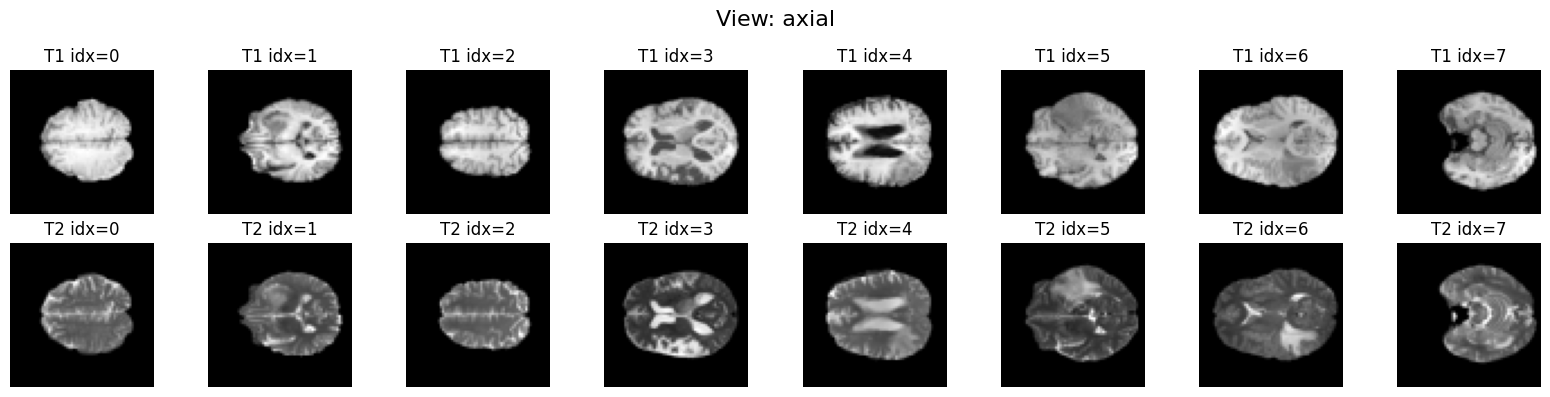

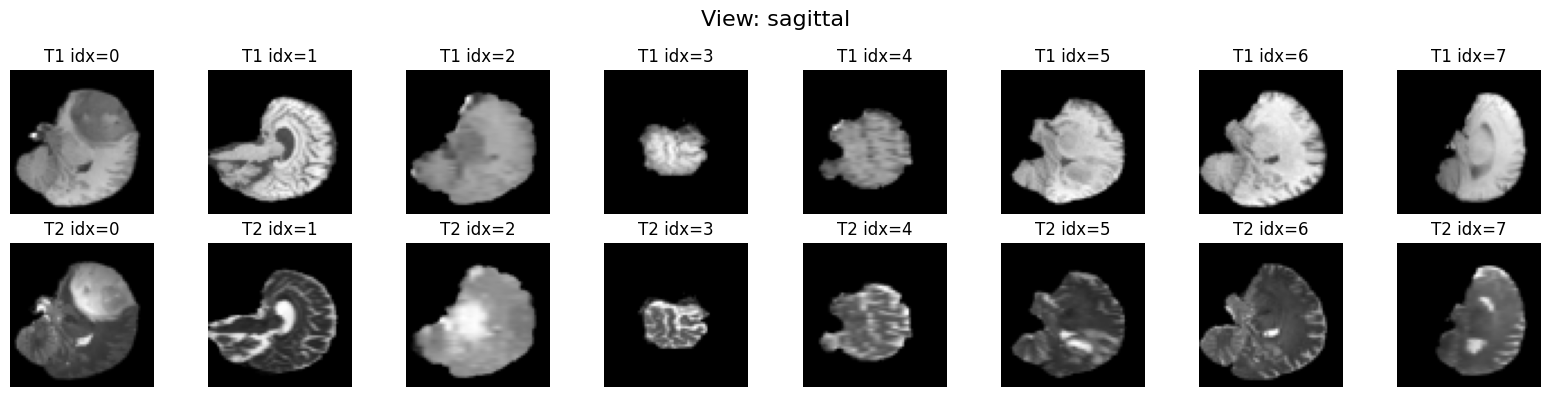

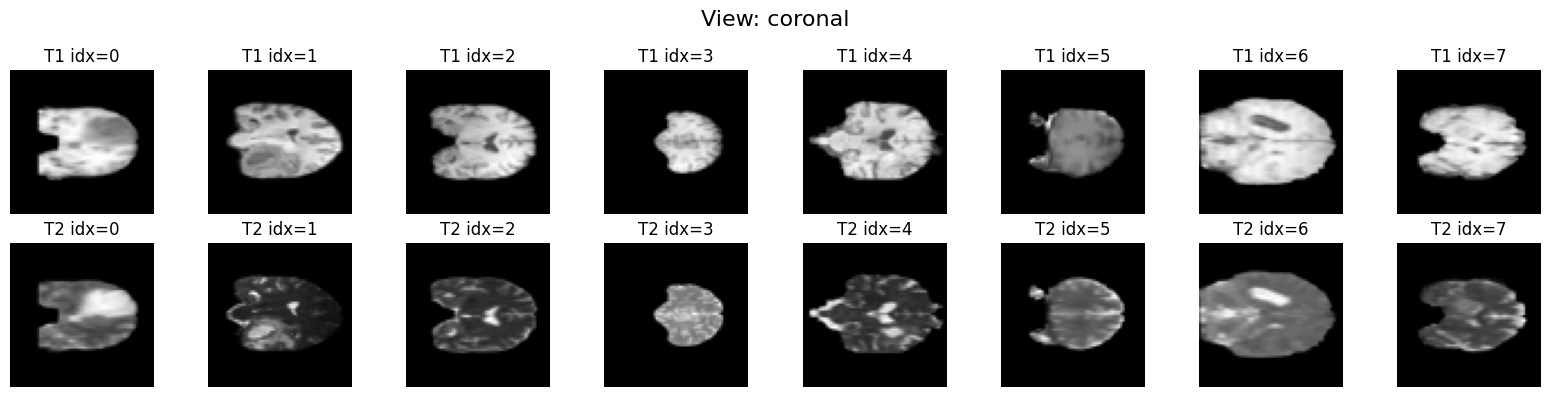

In [10]:
import torch
import random

def plot_sample_pairs(dataset, view_type, n=8):
    """Plot a small grid of 8 T1/T2 pairs from the training set.

    Parameters
    dataset:
      train and valid dataset with keys 'view', 't1', 't2'
    view: string
      to show 8 for "axial", "sagittal", "coronal" each
    n: int
      number of samples to display
    """
    # collect indices of samples with the desired view
    indices = [i for i, sample in enumerate(dataset) if sample["view"] == view_type]

    # Randomly choose n samples
    chosen_idx = random.sample(indices, n)

    # Get tensors
    pairs = [dataset[i] for i in chosen_idx]

    # plot
    fig, axes = plt.subplots(2, n, figsize=(2 * n, 4))

    for i, sample in enumerate(pairs):
        t1, t2 = sample["t1"][0], sample["t2"][0]

        # display T1 on the top row
        axes[0, i].imshow(t1, cmap="gray")
        axes[0, i].set_title(f"T1 idx={i}")
        axes[0, i].axis("off")       # hide axis ticks

        # display T2 on the bottom row
        axes[1, i].imshow(t2, cmap="gray")
        axes[1, i].set_title(f"T2 idx={i}")
        axes[1, i].axis("off")

    plt.suptitle(f"View: {view_type}", fontsize=16)      # overall title for the whole grid
    plt.tight_layout()
    plt.show()

for view_type in ["axial", "sagittal", "coronal"]:
  plot_sample_pairs(train_dataset, view_type)


<br>

2. **Analyse intensity distributions**  

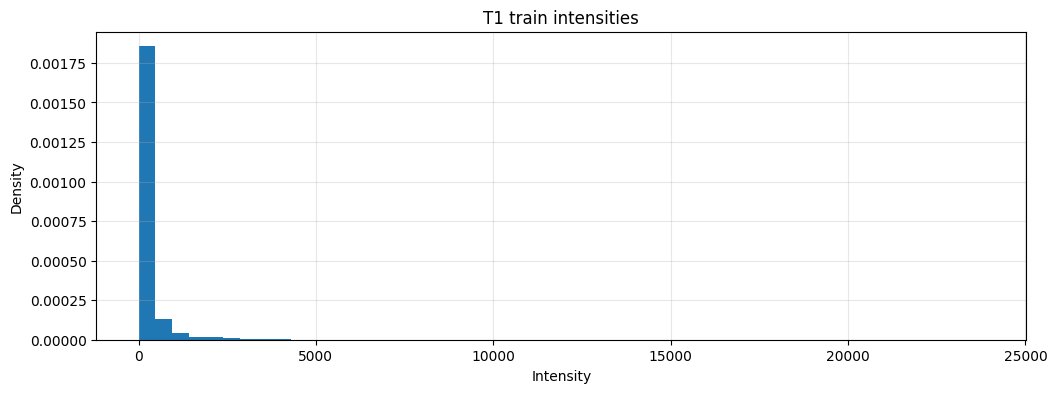

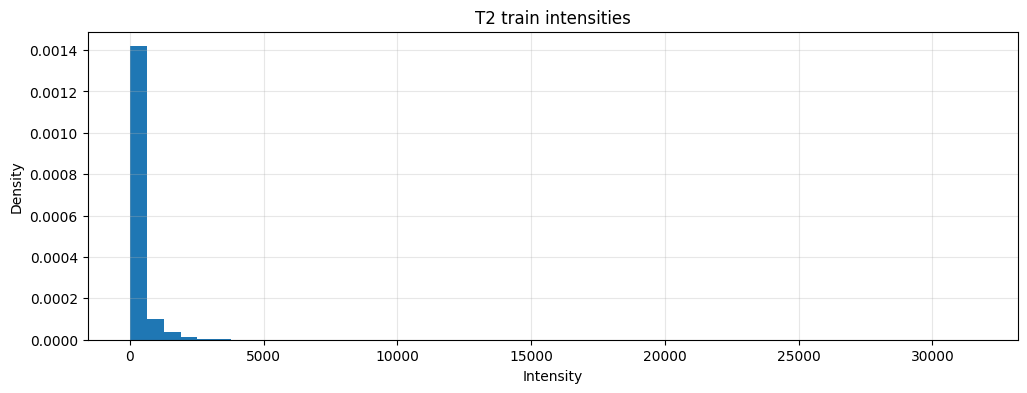

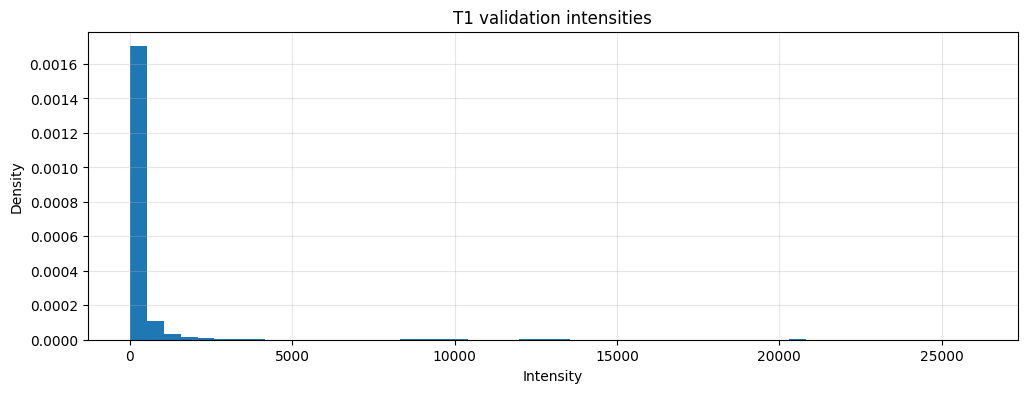

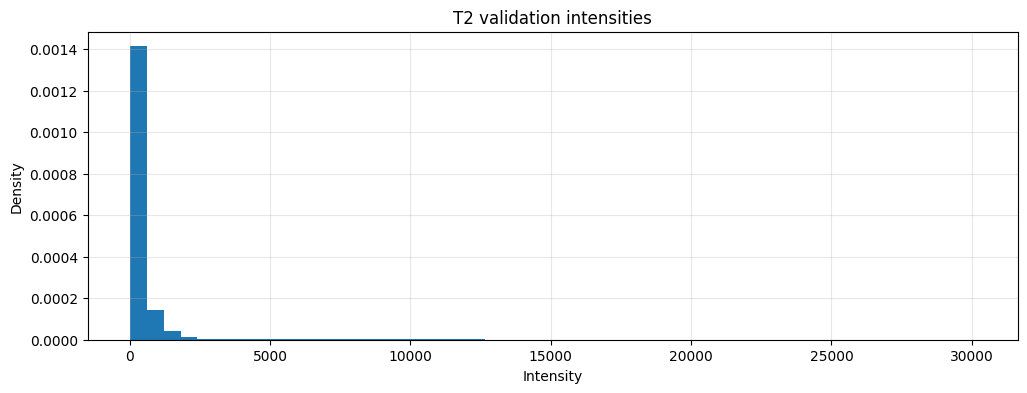

In [11]:
def collect_intensity(dataset, key, num_samples=1000):
    """
    Collect intensity distributions for T1 and T2 images.

    Parameters:
        dataset: The dataset to analyze
        key: given key "t1" or "t2"
        num_samples: number of samples to use for histogram
    Return:
        a 1D array of instensity histogram
    """
    # choose random indices within dataset length
    # avoid asking for more than available
    if len(dataset) > num_samples:
        indices = np.random.choice(len(dataset), num_samples, replace=False)
    else:
        indices = np.arange(len(dataset))

    # Initialize intensities
    intensities = []

    for idx in indices:
        sample = dataset[int(idx)]
        img = sample[key]
        intensities.append(img.numpy().flatten())

    intensities = np.concatenate(intensities, axis=0)
    # join all 1D arrays into one big array

    return intensities

t1_train_intens = collect_intensity(train_dataset, "t1")
t2_train_intens = collect_intensity(train_dataset, "t2")
t1_valid_intens = collect_intensity(valid_dataset, "t1")
t2_valid_intens = collect_intensity(valid_dataset, "t2")

# plot histograms
def plot_histogram(intensity, title):
    plt.figure(figsize=(12, 4))
    plt.hist(intensity, bins=50, density=True)   # 50 bins, density=True to see a probability-like curve
    plt.title(title)
    plt.xlabel("Intensity")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_histogram(t1_train_intens, "T1 train intensities")
plot_histogram(t2_train_intens, "T2 train intensities")
plot_histogram(t1_valid_intens, "T1 validation intensities")
plot_histogram(t2_valid_intens, "T2 validation intensities")

From the intensity histograms, it shows the range extends from 0 to 20000/30000, while the marjority of intensity values are small, concentrated within 0-2500. The long tails extend to high values indicate a small number of extremely bright regions. Hence an intensity normalization is required here.

<br>

3. **Design a simple intensity pre-processing transform**

In [16]:
import torch

class MRINormalization:
    """
    Normalization class for MRI T1 and T2 images.
    Based on histogram analysis, we apply per-slice min-max normalization to [0,1]
    """
    def __ini__(self,):
      pass

    def minmax_normalize(self, img_tensor):
        """
        Apply per-slice min–max normalization per slice.

        Parameters
        ----------
        img_tensor : torch.Tensor
            A tensor of shape (1, H, W) containing pixel intensities.

        Returns
        -------
        img_norm: torch.Tensor
            Normalized slice with values scaled to [0, 1].
        """

        # Compute minimum and maximum pixel values
        min_val = img_tensor.min()
        max_val = img_tensor.max()

        # Avoid division by zero if slice is constant
        if (max_val - min_val) > 0:
            img_norm = (img_tensor - min_val) / (max_val - min_val)
        else:
            img_norm = torch.zeros_like(img_tensor)

        return img_norm


    def __call__(self, sample):
        """
        Allow the class to act as the rransform function for the dataset.
        Converts arrays to tensors and applies per-slice min–max normalization
        to both T1 and T2 images.

        Parameters
        sample: dictionary
          original samples from dataset

        Return
        sample: dictionary
          sample after normalization
        """

        # Convert numpy arrays → float32 tensors
        t1 = torch.tensor(sample["t1"], dtype=torch.float32)
        t2 = torch.tensor(sample["t2"], dtype=torch.float32)

        # Normalise each slice independently
        t1 = self.minmax_normalize(t1)
        t2 = self.minmax_normalize(t2)

        # Put normalized data back into sample dictionary
        sample["t1"] = t1
        sample["t2"] = t2

        return sample

normalizer = MRINormalization()

train_dataset_norm = train_dataset.with_transform(normalizer)
valid_dataset_norm = valid_dataset.with_transform(normalizer)


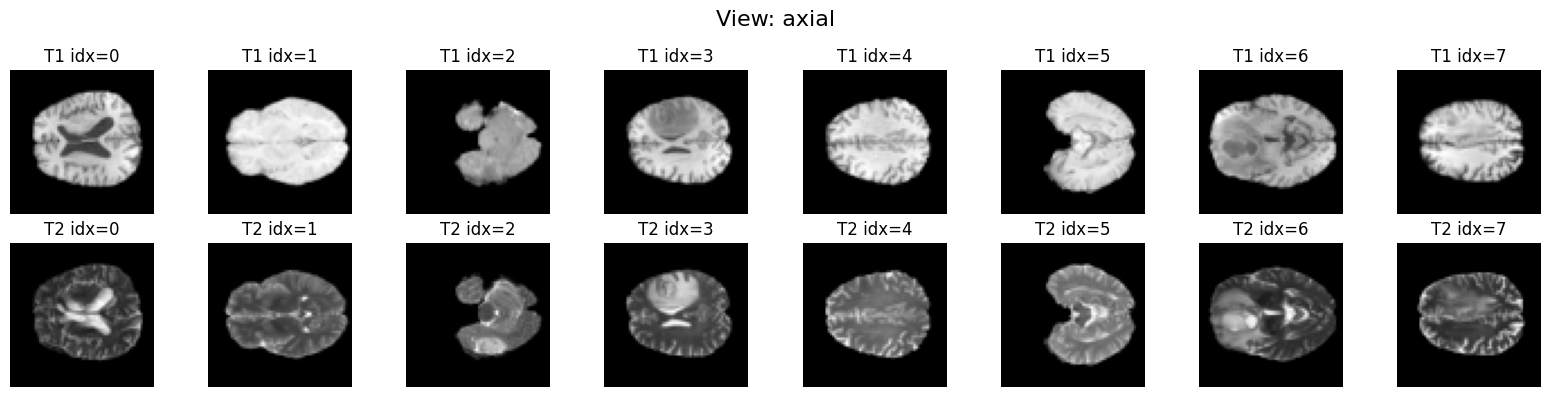

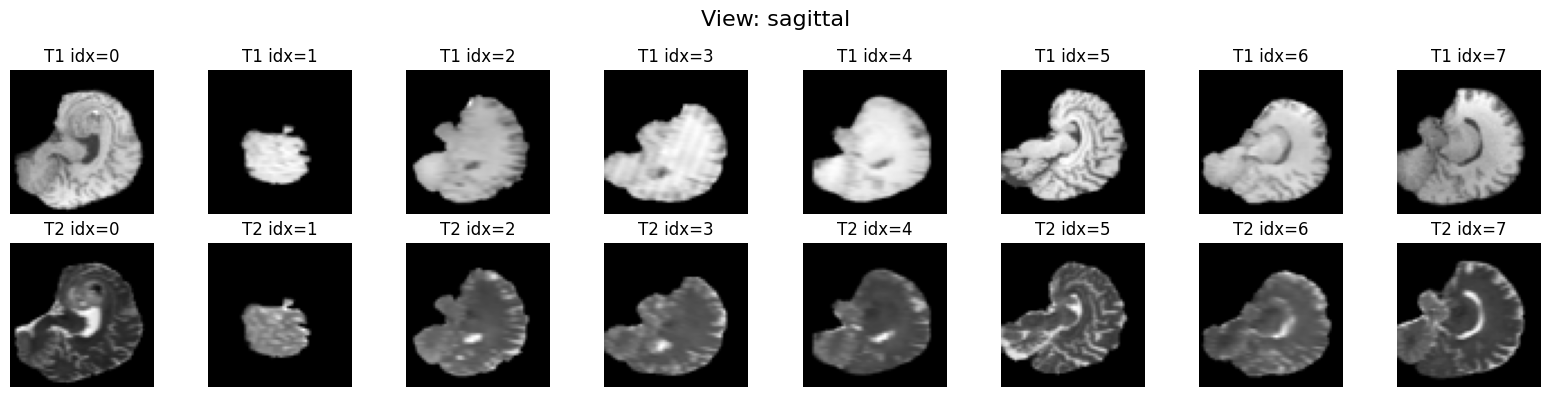

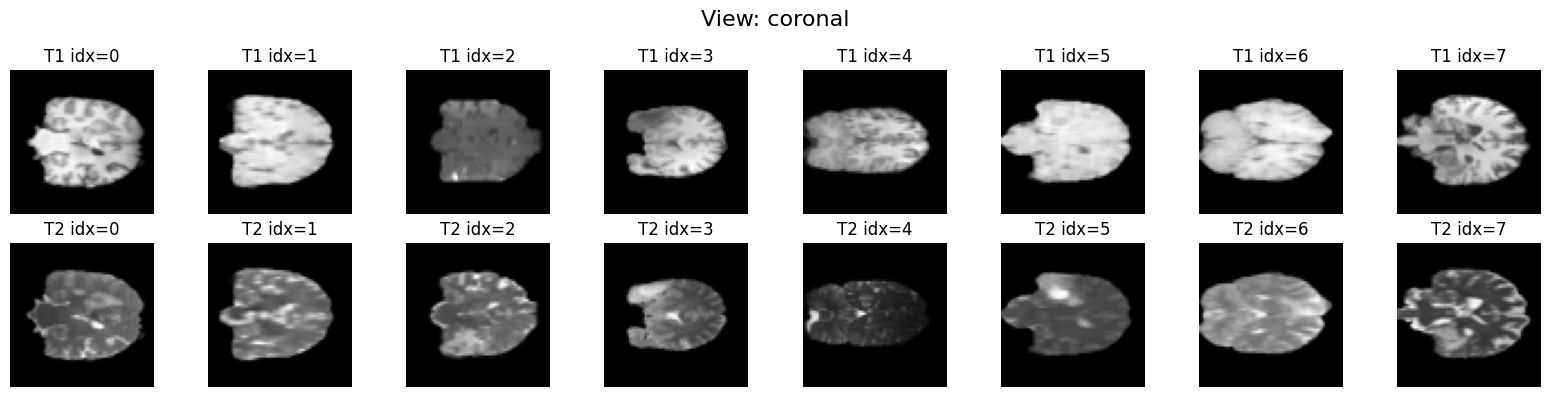

In [17]:
for view_type in ["axial", "sagittal", "coronal"]:
  plot_sample_pairs(train_dataset_norm, view_type)


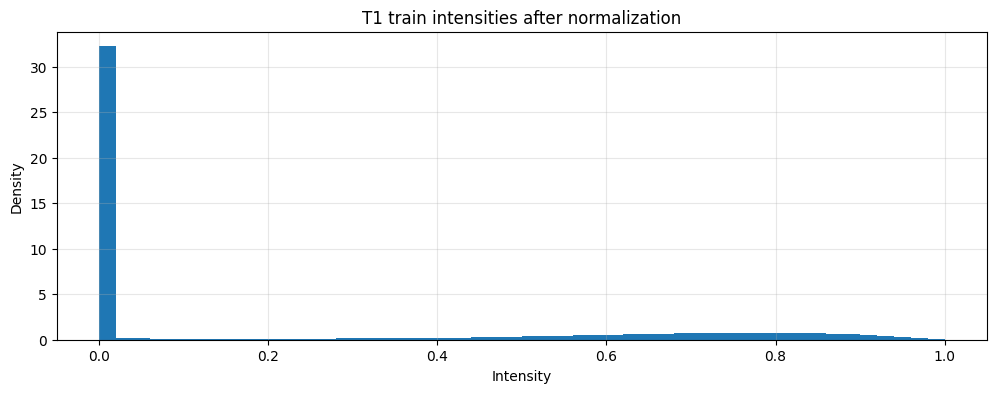

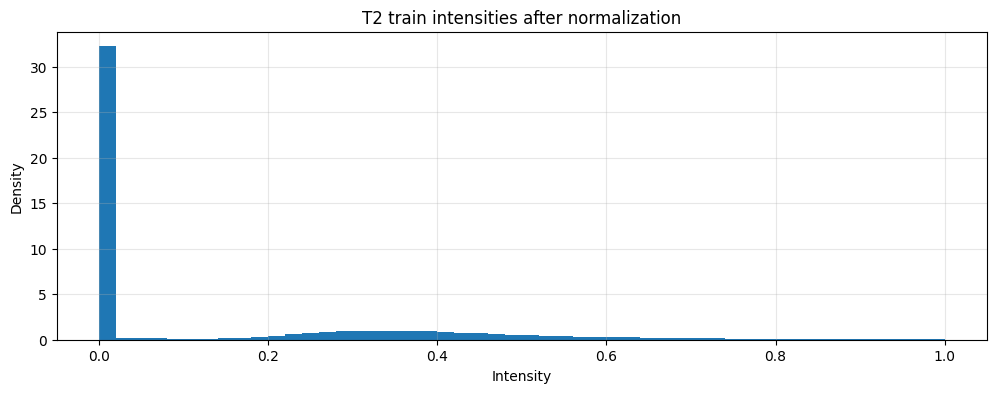

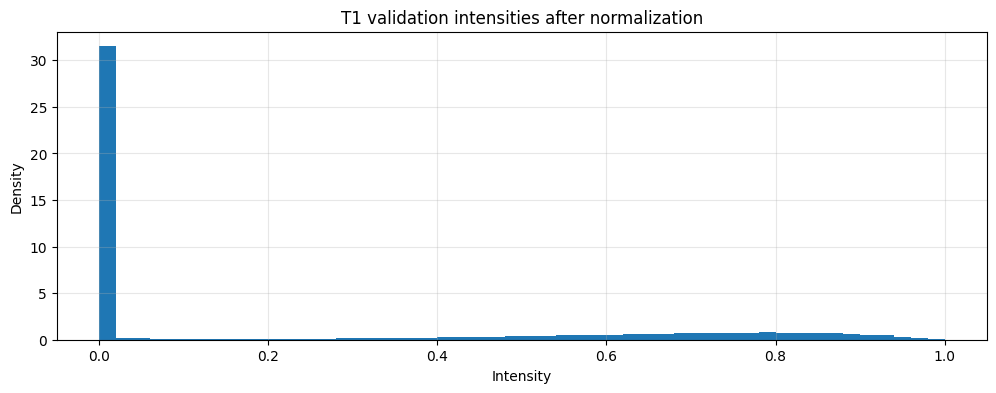

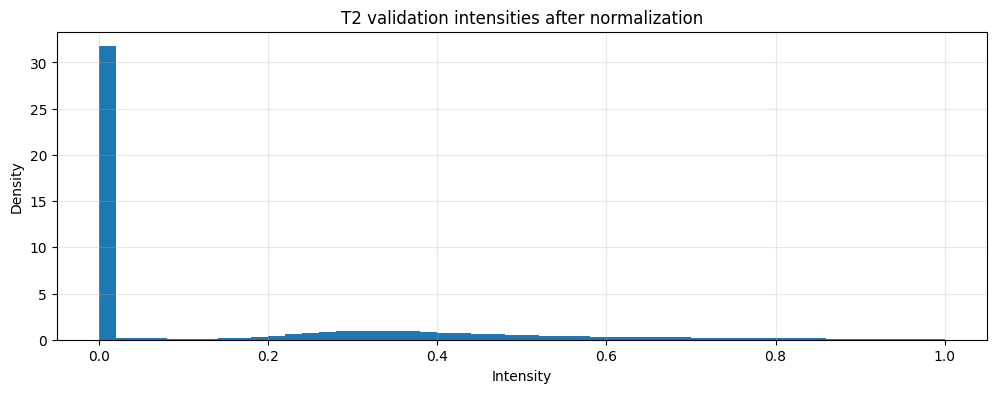

In [18]:

t1_train_intens_norm = collect_intensity(train_dataset_norm, "t1")
t2_train_intens_norm = collect_intensity(train_dataset_norm, "t2")
t1_valid_intens_norm = collect_intensity(valid_dataset_norm, "t1")
t2_valid_intens_norm = collect_intensity(valid_dataset_norm, "t2")


plot_histogram(t1_train_intens_norm, "T1 train intensities after normalization")
plot_histogram(t2_train_intens_norm, "T2 train intensities after normalization")
plot_histogram(t1_valid_intens_norm, "T1 validation intensities after normalization")
plot_histogram(t2_valid_intens_norm, "T2 validation intensities after normalization")

<br><br>

## 1.B) Modality Translation (T1 → T2)

In this part you will build an **image-to-image model** that takes a T1-weighted slice as input and predicts the corresponding T2-weighted slice. Each training example is therefore a pair $(\text{T1}, \text{T2})$ with matching spatial dimensions.

You are free to design the model architecture, but it must satisfy the following requirements:

- It should operate on 2D slices and produce an output with the **same spatial resolution** as the input
- It should take `t1` as input and learn to approximate `t2` as output, using the pre-processed data from Part 1.A.  

In designing your solution, you must determine:

- a **suitable architecture**, keeping in mind that simpler models should remain functional and that more complex designs may yield improved performance;  
- the **loss function** and **optimisation setup** you believe appropriate for this task;  
- the **evaluation strategy**, including at least one quantitative metric and the qualitative visualisation of predicted T2 images.

Key points to consider:

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem. **Strong solutions will ensure that the model can both preserve image quality and generalise well to the validation set.**

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays example outputs of your **final trained model on the validation set**, as well as at least one plot showing how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

In [ ]:
# U-net CNNs an GANs are recommended as the most frequently used model in industry,
# which was summarized from AI, here Unet would be used

# Refered to lecture

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")


# Initialize hyperparamters
set_seed(42)
p = 0.6
lr = 1e-3
batch_size = 64
num_workers = 0
wd = 1e-6
nepochs = 5

# Create Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [ ]:
!pip install pycm livelossplot
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary


# Simple U-net

class ConvBlock(nn.Module):
  """
  Basic building block of the U-Net.
  """
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(out_c)
    self.act = nn.ReLU()

  def forward(self, x):
      x = self.conv(x)
      x = self.bn(x)
      x = self.act(x)
      return x

# define an encoder block of the U-Net
class EncBlock(nn.Module):
    """
    Small U-net for 64x64 images
    1 input channel -> 1 output channel.
    """

    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv_block1 = ConvBlock(in_c, out_c)
        self.conv_block2 = ConvBlock(out_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        h = self.conv_block1(x)
        h = self.conv_block2(h)
        p = self.pool(h)
        return h, p

# define an decoder block of the U-Net
class DecBlock(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(2*out_c, out_c)
        self.conv_block2 = ConvBlock(out_c, out_c)

    def forward(self, x, s):
        h = self.up(x)
        h = torch.cat([h, s], axis=1) # concatenate x with U-Net skip connection from encoder
        h = self.conv_block1(h)
        h = self.conv_block2(h)
        return h


In [ ]:
class Unet(nn.Module):

    def __init__(self, n_channels):
        super().__init__()

        # encoder
        self.e1 = EncBlock(n_channels, 16)
        self.e2 = EncBlock(16, 32)

        # bottleneck
        self.b1 = ConvBlock(32, 128)

        # decoder
        self.d4 = DecBlock(128, 64)

        # output layer
        self.output = nn.Conv2d(64, n_channels, kernel_size=1, padding=0)

    def forward(self, x):

        # encoder
        s1, x = self.e1(x)

        # bottleneck
        x = self.b1(x)

        # decoder
        x = self.d4(x, s1)

        # output
        output = self.output(x)

        return output

model = Unet(n_channels=1).to(device)

# Test model
output = model(torch.ones(1, 1, 28, 28).to(device))
print(output.shape)

# Print model
summ = summary(model, input_size=(1, 28, 28))

In [ ]:
mseloss = nn.MSELoss()

In [ ]:
optimiser = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss*input.size(0)
        optimizer.step()
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss


def valid(model, criterion, data_loader):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            loss = criterion(output, target)
            valid_loss += loss*input.size(0)
        valid_loss = valid_loss / len(data_loader.dataset)
        return valid_loss


def test(model, data_loader):
    model.eval()
    targets = []
    outputs = []
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            targets.append(target)
            outputs.append(output)
        return torch.cat(targets), torch.cat(outputs)

In [ ]:
liveloss = PlotLosses()
for i in range(nepochs):
    train_loss = train(model, optimiser, mseloss, train_loader)
    valid_loss = valid(model, mseloss, valid_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()

    # Visualise a random validation sample
    valid_sample, valid_target = valid_dataset[torch.randint(0, len(valid_dataset), (1,)).item()]
    output_sample = model(valid_sample.unsqueeze(0).to(device))
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(valid_sample[0].cpu(), cmap="gray")
    axs[1].imshow(valid_target[0].cpu(), cmap="gray")
    axs[2].imshow(output_sample[0, 0].detach().cpu(), cmap="gray")
    plt.show()

In [ ]:
!mkdir '/content/drive/My Drive/models'  # create the director for storing the model in Google Drive

model_save_name = 'MRI_UNet_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/drive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage
torch.save(model.state_dict(), path)

model.load_state_dict(torch.load(path)) # loads the parameters of the model in path. state_dict is a dictionary object that maps each layer in the model to its trainable parameters (weights and biases).


In [ ]:
target, output = test(model, test_loader)
target, output = target[:32], output[:32]

target_grid = make_grid(target)
output_grid = make_grid(output)

plt.figure(figsize=(10,10))
plt.imshow(target_grid.detach().cpu().permute(1,2,0))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(output_grid.detach().cpu().permute(1,2,0))
plt.show()

<br><br>

## 1.C) Discussion (max 250 words)

In this part you should provide a concise written discussion (maximum **250 words**) reflecting on your solution to Part 1.B. Your discussion should address the following points:

1. **Modelling choices and pre-processing**  
   Explain the main decisions behind your model architecture, loss function, and training strategy, and how they relate to the properties of the T1/T2 translation task.

2. **Performance and evaluation**  
   Interpret your **quantitative** results and **qualitative** reconstructions. Comment on how well your model appears to reconstruct `t2` features.

3. **Limitations and possible improvements**  
   Identify the main limitations of your current approach and outline concrete avenues for improvement. You may refer to alternative architectures, loss functions, or improved training and validation procedures.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

// Text answer
only text and images
qualitative results and loss
further improvements

<br>

---

<br>